##                           FashionMart - Market Basket Analysis  - Segmenting Customers RMF for cross selling 

In [154]:
########################################################################################################################
#
# Script name               - Market_Basket_analysis-Customer_Segments_new.ipynb
# Script description        - This notebook will do download data from cloud and do cohart analysis based on different
#                              dataset
# Usage                     - 
# Input Params needed       - 
#
#
#  Date                        Author                        Modification                       Description
# =====                       =======                        =============                     =============
# 17-Sep-2019                 Praveen                        Created
#
#
########################################################################################################################

## Business description

Imprting necessary libraries 

In [155]:
import reusables as re
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import math
import matplotlib.mlab as mlab

warnings.simplefilter('ignore')

In [156]:
script_name='CC_2_FashinMart_Cohort_analysis'
reusable = re.reusables()

## Data preperation

In [157]:
df_mba_data = pd.read_csv(reusable.path_sources+'exercise2_input.csv',converters={'Quantity':int,'Sales':float})

In [158]:
df_mba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 8 columns):
RowID          9994 non-null int64
OrderID        9994 non-null object
OrderDate      9994 non-null object
CustomerID     9994 non-null object
ProductID      9994 non-null object
ProductName    9994 non-null object
Sales          9994 non-null float64
Quantity       9994 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 624.7+ KB


## Formating date & adding date related features 

In [7]:
df_mba_data['OrderDate'] = pd.to_datetime(df_mba_data['OrderDate'])

# Now extract the month, year, day, weekday
df_mba_data["month"] = df_mba_data["OrderDate"].dt.month
df_mba_data["year"] = df_mba_data["OrderDate"].dt.year
df_mba_data['week'] = df_mba_data["OrderDate"].dt.weekofyear
df_mba_data['dayofweek'] = df_mba_data['OrderDate'].dt.dayofweek
df_mba_data['days'] = (datetime.date(2014, 1, 1) - df_mba_data['OrderDate'].dt.date).dt.days
df_mba_data['quarter'] = df_mba_data['OrderDate'].dt.quarter
df_mba_data['is_month_start'] = df_mba_data['OrderDate'].dt.is_month_start

In [159]:
df_mba_data.columns

Index(['RowID', 'OrderID', 'OrderDate', 'CustomerID', 'ProductID',
       'ProductName', 'Sales', 'Quantity'],
      dtype='object')

## Top Customers contributing to 10% of total Sales

In [11]:
(df_mba_data.CustomerID.value_counts()/sum(df_mba_data.CustomerID.value_counts())*100).head(n=13).cumsum()

WB-21850    0.370222
JL-15835    0.710426
MA-17560    1.050630
PP-18955    1.390835
CK-12205    1.711027
JD-15895    2.031219
EH-13765    2.351411
SV-20365    2.671603
ZC-21910    2.981789
EP-13915    3.291975
AP-10915    3.602161
LC-16870    3.902341
Dp-13240    4.192516
Name: CustomerID, dtype: float64

In [13]:
#df_mba_data.groupby(["ProductID","ProductName"]).count().reset_index()

In [16]:
df_mba_data.ProductID.value_counts()[df_mba_data.ProductID.value_counts()>1].reset_index().head()

,index,ProductID
0,OFF-PA-10001970,19
1,TEC-AC-10003832,18
2,FUR-FU-10004270,16
3,FUR-CH-10002647,15
4,TEC-AC-10003628,15


## Stand. the data 

In [23]:
df_cust_Seg = df_mba_data.groupby(['year','CustomerID','OrderDate','ProductID','ProductName']).agg({'Sales':'sum', 'Quantity':'sum'}).reset_index()

## Data cleaning

In [27]:
# Remove negative or return transactions
df_cust_Seg = df_cust_Seg[df_cust_Seg.Sales>0]
df_cust_Seg = df_cust_Seg[~(df_cust_Seg.CustomerID.isnull())]

## Building the necessary features for clustering 

In [29]:
print('Minimum date to which transaction happen => '+str(min(df_cust_Seg['OrderDate'])))
print('Maximum date to which transaction happen => '+str(max(df_cust_Seg['OrderDate'])))

Minimum date to which transaction happen => 2014-01-02 00:00:00
Maximum date to which transaction happen => 2017-12-30 00:00:00


In [30]:

refrence_date = df_cust_Seg.OrderDate.max()
refrence_date = refrence_date + datetime.timedelta(days = 1)

In [32]:
df_cust_Seg['days_since_last_purchase'] = refrence_date - df_cust_Seg.OrderDate
df_cust_Seg['days_since_last_purchase_num'] = df_cust_Seg['days_since_last_purchase'].astype('timedelta64[D]')

In [33]:
df_cust_Seg.head()

,year,CustomerID,OrderDate,ProductID,ProductName,Sales,Quantity,days_since_last_purchase,days_since_last_purchase_num
0,2014,AA-10315,2014-03-31,OFF-AP-10002765,Fellowes Advanced Computer Series Surge Protec...,52.980,2,1371 days,1371.0
1,2014,AA-10315,2014-03-31,OFF-BI-10004390,GBC DocuBind 200 Manual Binding Machine,673.568,2,1371 days,1371.0
2,2014,AA-10315,2014-09-15,FUR-FU-10002456,"Master Caster Door Stop, Large Neon Orange",14.560,2,1203 days,1203.0
3,2014,AA-10315,2014-09-15,OFF-PA-10000349,Easy-staple paper,14.940,3,1203 days,1203.0
4,2014,AA-10375,2014-04-21,OFF-BI-10002976,ACCOHIDE Binder by Acco,16.520,5,1350 days,1350.0


## Time period of transactions

In [35]:
customer_history_df = df_cust_Seg.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df.rename(columns={'days_since_last_purchase_num':'recency'}, inplace=True)
customer_history_df.recency.describe()

count     793.000000
mean      164.388398
std       190.497184
min         1.000000
25%        38.000000
50%        97.000000
75%       219.000000
max      1166.000000
Name: recency, dtype: float64

## Fequency of Customer Purchase in FashinMart 

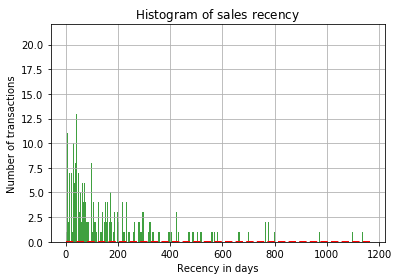

In [45]:
x = customer_history_df.recency
mu = np.mean(customer_history_df.recency)
sigma = math.sqrt(np.var(customer_history_df.recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
# add a 'best fit' line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

## Adding Frequency & Monetary values

In [48]:
customer_monetary_val = df_cust_Seg[['CustomerID', 'Sales']].groupby("CustomerID").sum().reset_index()

customer_history_df = customer_history_df.merge(customer_monetary_val, how='outer')
customer_history_df.amount = customer_history_df.Sales+0.001


customer_freq = df_cust_Seg[['CustomerID', 'Sales']].groupby("CustomerID").count().reset_index()
customer_freq.rename(columns={'Sales':'frequency'},inplace=True)

customer_history_df = customer_history_df.merge(customer_freq, how='outer')

In [50]:
customer_history_df.describe()

,recency,Sales,frequency
count,793.000000,793.000000,793.000000
mean,164.388398,2896.848500,12.592686
std,190.497184,2628.670117,6.229759
min,1.000000,4.833000,1.000000
25%,38.000000,1146.050000,8.000000
50%,97.000000,2256.394000,12.000000
75%,219.000000,3785.276000,16.000000
max,1166.000000,25043.050000,37.000000


Based on the above abservation mean of the recency , monetary & frequency metrics is to diverse , 
So we need to normalise with the help to natural log. Value should be standardised using standard scalar techniques

In [51]:
from sklearn import preprocessing
import math

customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['Sales_log'] = customer_history_df['Sales'].apply(math.log)
feature_vector = ['Sales_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector].as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)

In [ ]:
Let see the distribution of 

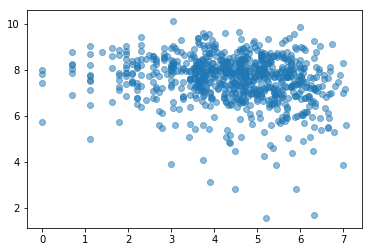

In [54]:
plt.scatter(customer_history_df.recency_log, customer_history_df.Sales_log, alpha=0.5)

Let see how the non linearity components is linearised after taking log

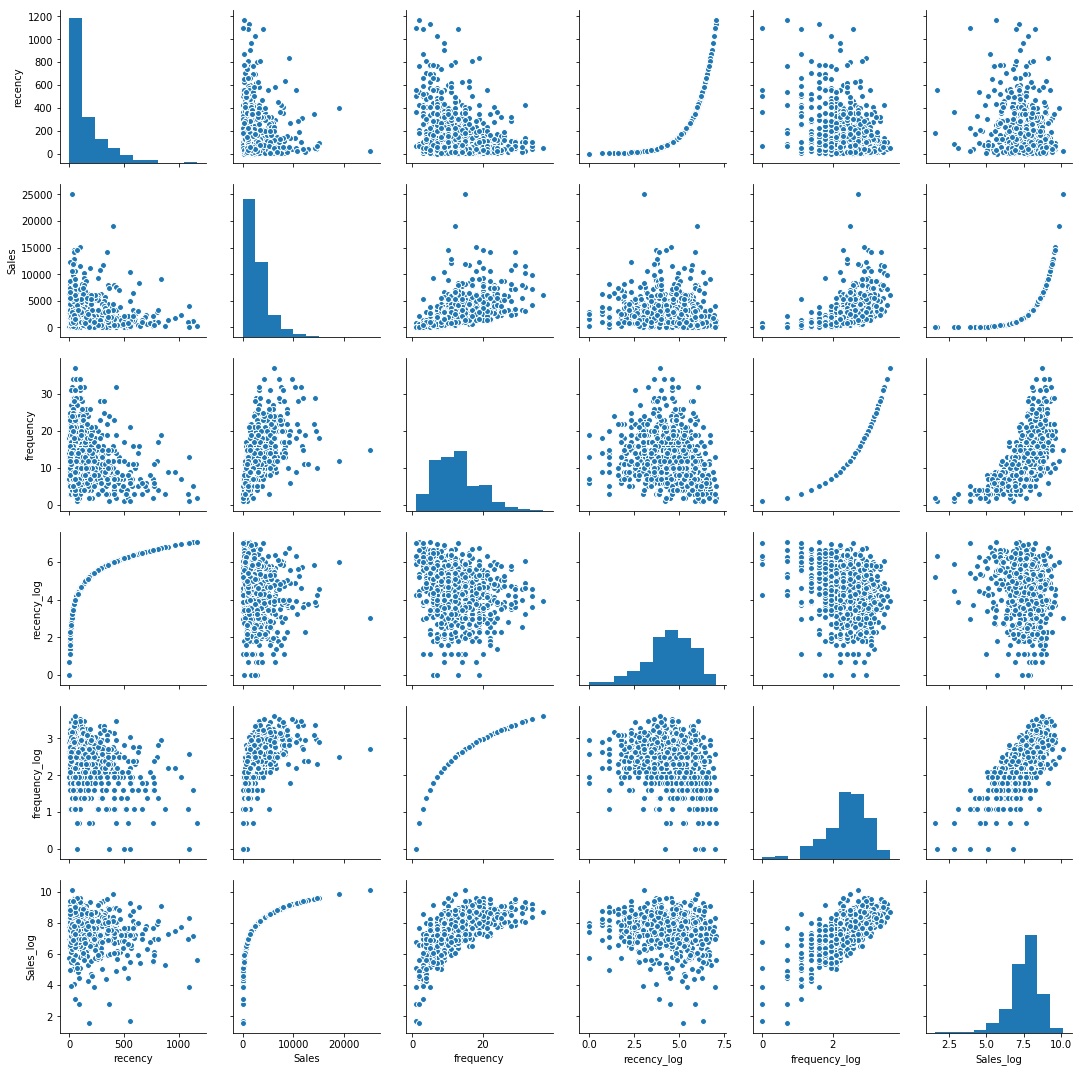

In [55]:
sns.pairplot(customer_history_df)

## Visualising Scaled monetary value distribution 

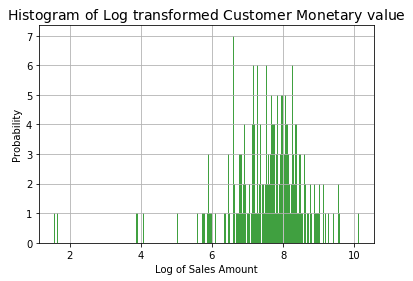

In [58]:

x = customer_history_df.Sales_log
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)

plt.xlabel('Log of Sales Amount')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $',size=14)
plt.grid(True)
#plt.show()

Its observed from the above graph , log Sales amount follows the normal distribution.It really great for our Customer segmentation

## Let see how the Recency , Frequency & Monetary values relate to each other

Text(0.5,0,'Monetary')

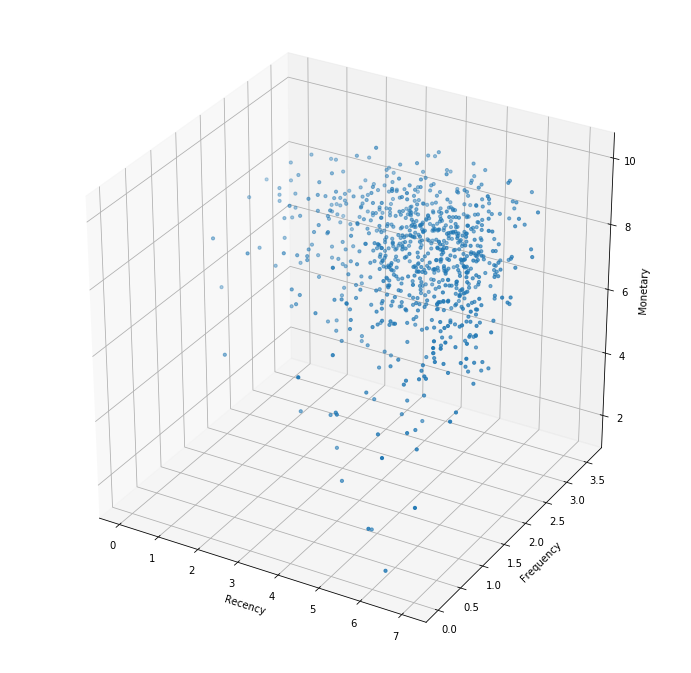

In [63]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.Sales_log
ax.scatter(xs, ys, zs, )

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')


Based on the above observation , We need to do outlier treatment before segmentation

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [ ]:
cm.colors

## Implementing Clustering techniques

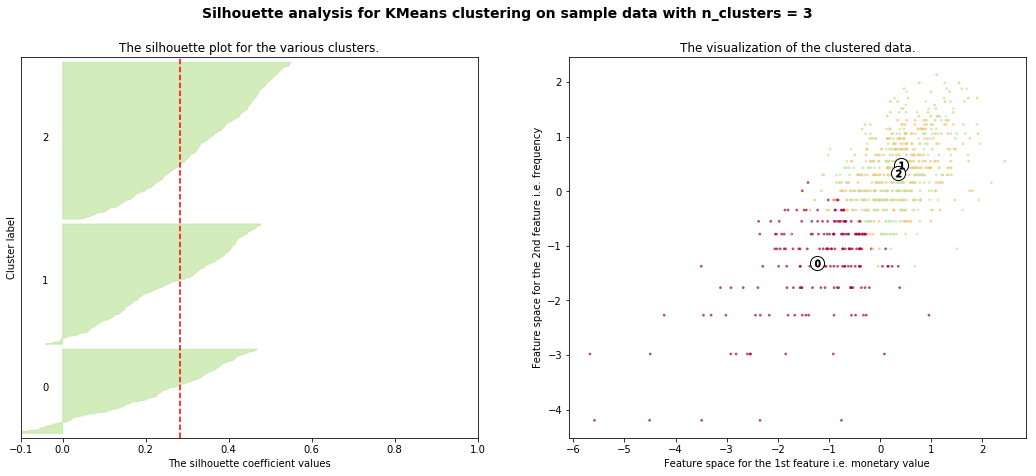

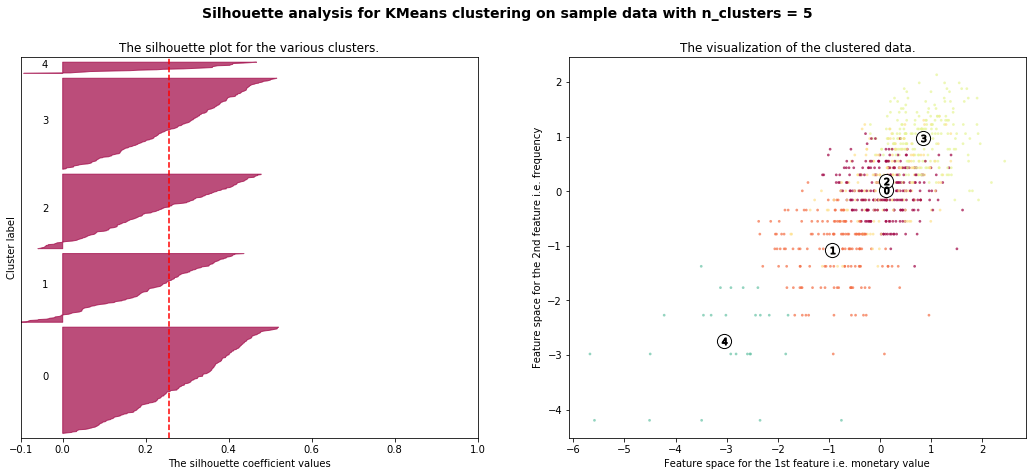

In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    #ax2 = plt.subplot(111, projection='3d')
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(cluster_labels.astype(float) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.show()


## Customer Cluster Statistics

In [86]:
for i in range(3,6,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=feature_vector))
    print("Silhouette score for cluster {} is {} - ". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
     Sales_log  recency_log  frequency_log
0   521.907860   162.490685       5.167845
1  2948.418093    20.208207      14.450506
2  2773.894190   169.564092      13.257910
Silhouette score for cluster 3 is 0.2816507400672864 - 

for 5 number of clusters
     Sales_log  recency_log  frequency_log
0  2185.801732   188.799017      11.146471
1   717.908786   174.133548       5.918063
2  2178.131983    13.585626      12.176224
3  4686.983409    72.202060      19.108316
4    76.399085   168.516465       2.285279
Silhouette score for cluster 5 is 0.25639148457572714 - 



In [79]:
labels = cluster_centers[5]['labels']   
customer_history_df['num_cluster5_labels'] = labels
labels = cluster_centers[3]['labels']
customer_history_df['num_cluster3_labels'] = labels

In [89]:
customer_history_df.head(10)

,CustomerID,recency,Sales,frequency,recency_log,frequency_log,Sales_log,num_cluster5_labels,num_cluster3_labels
0,AA-10315,185.0,5563.560,11,5.220356,2.397895,8.623993,0,2
1,AA-10375,49.0,1056.390,15,3.891820,2.708050,6.962613,2,1
2,AA-10480,260.0,1790.512,12,5.560682,2.484907,7.490257,0,2
3,AA-10645,234.0,5086.935,18,5.455321,2.890372,8.534431,3,2
4,AB-10015,446.0,886.156,6,6.100319,1.791759,6.786893,1,0
5,AB-10060,106.0,7755.620,17,4.663439,2.833213,8.956173,3,2
6,AB-10105,42.0,14473.571,20,3.737670,2.995732,9.580080,3,1
7,AB-10150,42.0,966.710,12,3.737670,2.484907,6.873899,2,1
8,AB-10165,107.0,1113.838,14,4.672829,2.639057,7.015567,0,2
9,AB-10255,167.0,914.532,14,5.117994,2.639057,6.818412,0,2


## Let see how the Customer segments look like in Sales , frequency & recency perspective 

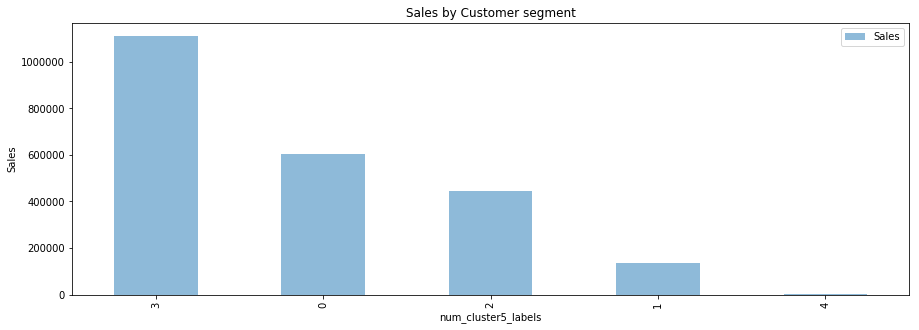

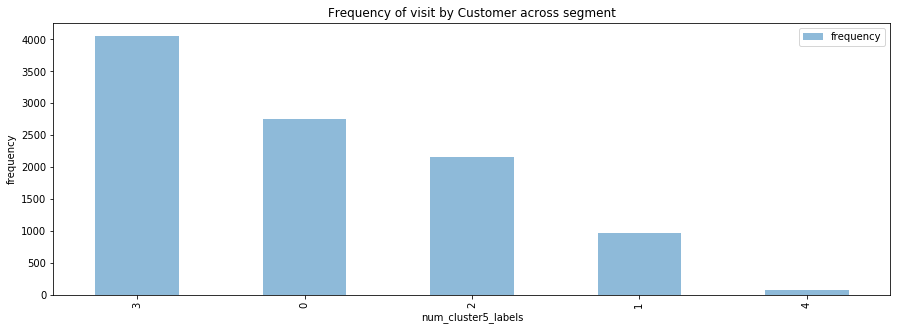

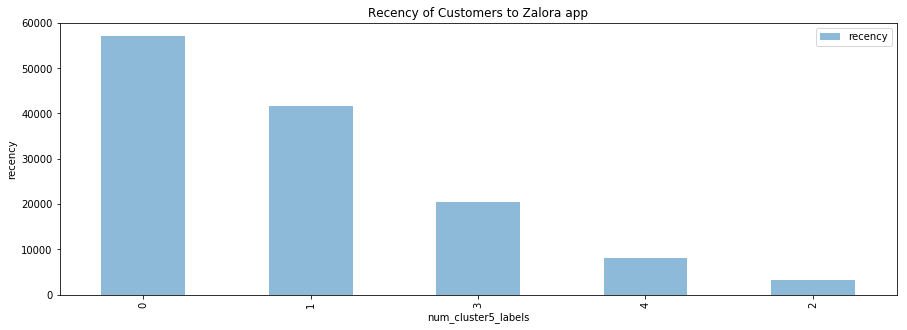

In [99]:
customer_history_df.groupby("num_cluster5_labels").aggregate({"Sales": "sum"}).sort_values('Sales', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Sales by Customer segment",size=12)
plt.ylabel("Sales")
plt.show() 

customer_history_df.groupby("num_cluster5_labels").aggregate({"frequency": "sum"}).sort_values('frequency', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Frequency of visit by Customer across segment",size=12)
plt.ylabel("frequency")
plt.show()

customer_history_df.groupby("num_cluster5_labels").aggregate({"recency": "sum"}).sort_values('recency', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Recency of Customers to FashinMart app",size=12)
plt.ylabel("recency")
plt.show() 

From the above graph , Its is clear that recency , frequency & Sales amounts are higher , because we considered all the 4 years of customer data for clustering.Ideally we should do clustering customers based on yearly basis.We need to check how the Customer journey lookes like for last 4 year

## How 3 segment cluster look like 

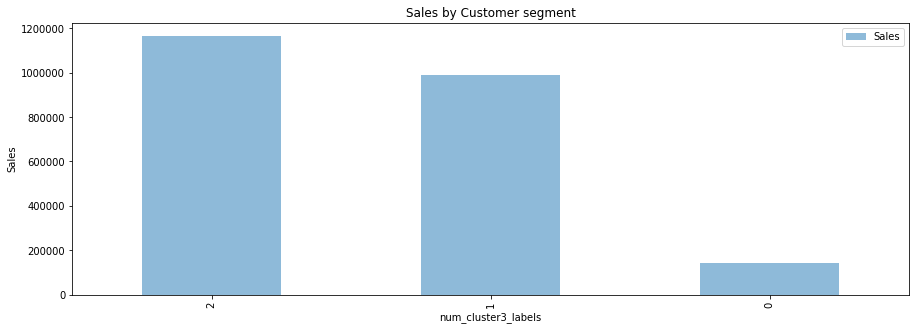

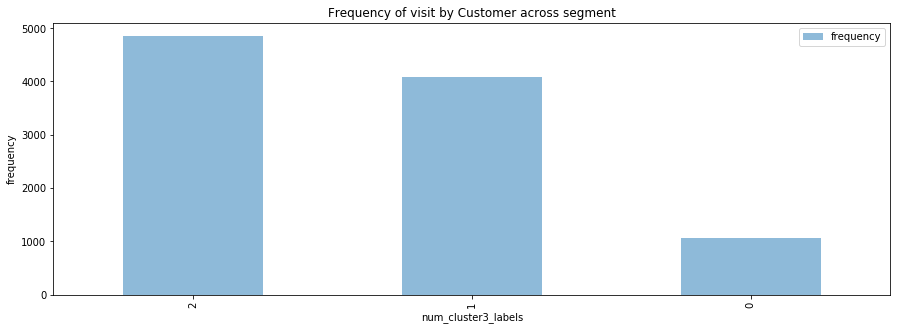

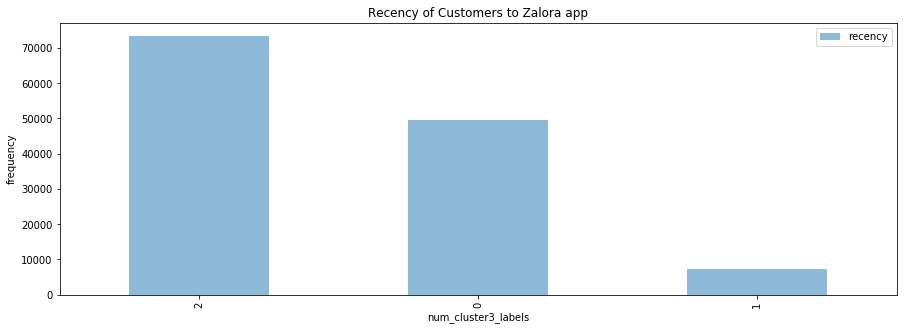

In [98]:
customer_history_df.groupby("num_cluster3_labels").aggregate({"Sales": "sum"}).sort_values('Sales', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Sales by Customer segment",size=12)
plt.ylabel("Sales")
plt.show() 

customer_history_df.groupby("num_cluster3_labels").aggregate({"frequency": "sum"}).sort_values('frequency', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Frequency of visit by Customer across segment",size=12)
plt.ylabel("frequency")
plt.show()

customer_history_df.groupby("num_cluster3_labels").aggregate({"recency": "sum"}).sort_values('recency', ascending=False).plot(kind="bar", alpha=.5, figsize=(15, 5))
plt.title("Recency of Customers to FashinMart app",size=12)
plt.ylabel("recency")
plt.show() 

## Understanding Customer Behavior by tagging customer segment to master dataset

In [106]:
cust_seg = customer_history_df[['CustomerID','num_cluster5_labels']]
df_cust_Seg_new = pd.merge(df_cust_Seg,cust_seg,left_on=['CustomerID'],right_on=['CustomerID'],how='left')

## Monthly Sales in FashinMart by Customer Segments 

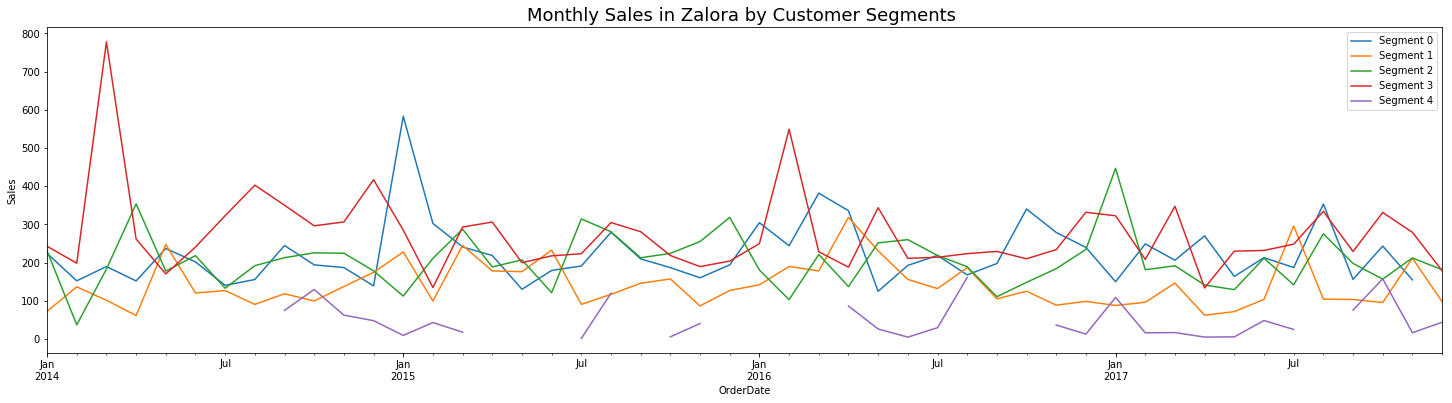

In [114]:
plt.title("Monthly Sales in FashinMart by Customer Segments ",size=18)
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==0].set_index("OrderDate")["Sales"].resample("M").mean().plot(figsize=(25, 6), label="Segment 0")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==1].set_index("OrderDate")["Sales"].resample("M").mean().plot(figsize=(25, 6), label="Segment 1")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==2].set_index("OrderDate")["Sales"].resample("M").mean().plot(figsize=(25, 6), label="Segment 2")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==3].set_index("OrderDate")["Sales"].resample("M").mean().plot(figsize=(25, 6), label="Segment 3")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==4].set_index("OrderDate")["Sales"].resample("M").mean().plot(figsize=(25, 6), label="Segment 4")

#ax = df_mba_data.set_index("OrderDate")["Sales"].resample("W").median().plot(figsize=(20, 6), label="Median")
#ax = df_mba_data.set_index("OrderDate")["Sales"].resample("W").std().plot(figsize=(20, 6), label="Std")

_ = ax.set_ylabel("Sales")
_ = plt.legend(loc="best")

# plot a heat map by month & Week 

plt.show()

## Quantities of items FashinMart by customer segments by month

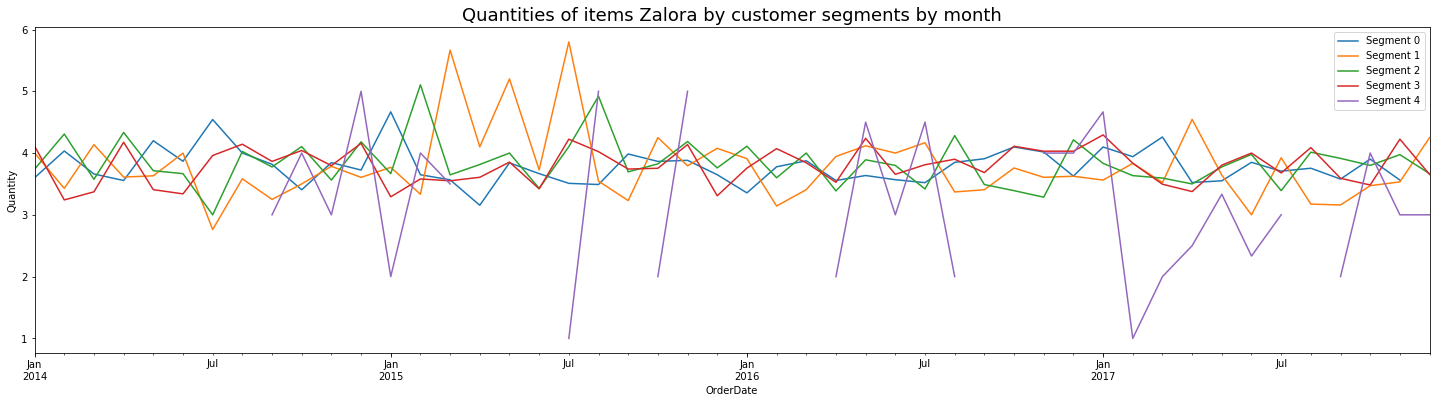

In [120]:
plt.title("Quantities of items FashinMart by customer segments by month",size=18)
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==0].set_index("OrderDate")["Quantity"].resample("M").mean().plot(figsize=(25, 6), label="Segment 0")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==1].set_index("OrderDate")["Quantity"].resample("M").mean().plot(figsize=(25, 6), label="Segment 1")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==2].set_index("OrderDate")["Quantity"].resample("M").mean().plot(figsize=(25, 6), label="Segment 2")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==3].set_index("OrderDate")["Quantity"].resample("M").mean().plot(figsize=(25, 6), label="Segment 3")
ax = df_cust_Seg_new.loc[df_cust_Seg_new['num_cluster5_labels']==4].set_index("OrderDate")["Quantity"].resample("M").mean().plot(figsize=(25, 6), label="Segment 4")

#ax = df_mba_data.set_index("OrderDate")["Sales"].resample("W").median().plot(figsize=(20, 6), label="Median")
#ax = df_mba_data.set_index("OrderDate")["Sales"].resample("W").std().plot(figsize=(20, 6), label="Std")

_ = ax.set_ylabel("Quantity")
_ = plt.legend(loc="best")

# plot a heat map by month & Week 

plt.show()

In [124]:
df_cust_Seg_new.columns

Index(['year', 'CustomerID', 'OrderDate', 'ProductID', 'ProductName', 'Sales',
       'Quantity', 'days_since_last_purchase', 'days_since_last_purchase_num',
       'num_cluster5_labels', 'month', 'week', 'dayofweek', 'days', 'quarter',
       'is_month_start'],
      dtype='object')

In [123]:
df_cust_Seg_new["month"] = df_cust_Seg_new["OrderDate"].dt.month
df_cust_Seg_new['week'] = df_cust_Seg_new["OrderDate"].dt.weekofyear
df_cust_Seg_new['dayofweek'] = df_cust_Seg_new['OrderDate'].dt.dayofweek
df_cust_Seg_new['days'] = (datetime.date(2014, 1, 1) - df_cust_Seg_new['OrderDate'].dt.date).dt.days
df_cust_Seg_new['quarter'] = df_cust_Seg_new['OrderDate'].dt.quarter
df_cust_Seg_new['is_month_start'] = df_cust_Seg_new['OrderDate'].dt.is_month_start

## How the Sales & Quantities accross segment look like for 2014,2015,2016 & 2017 

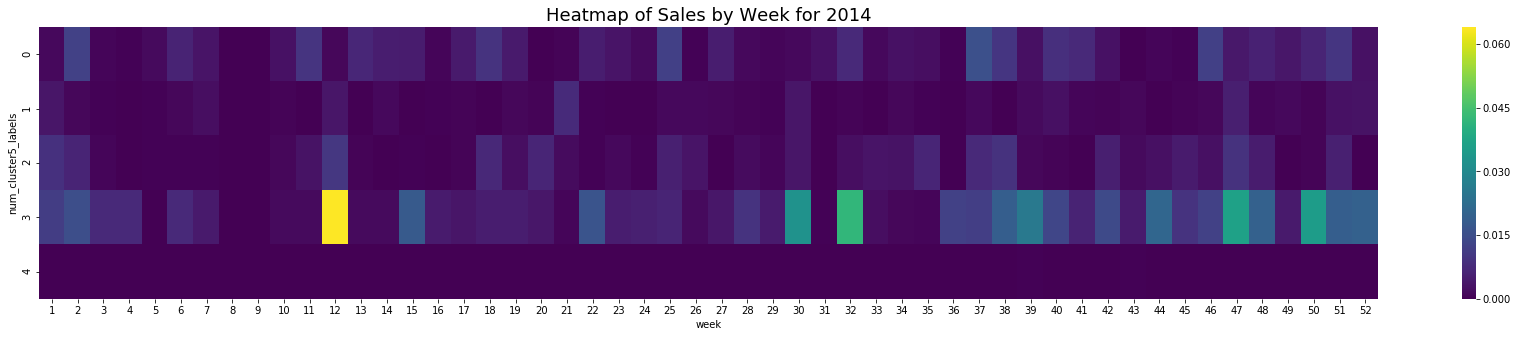

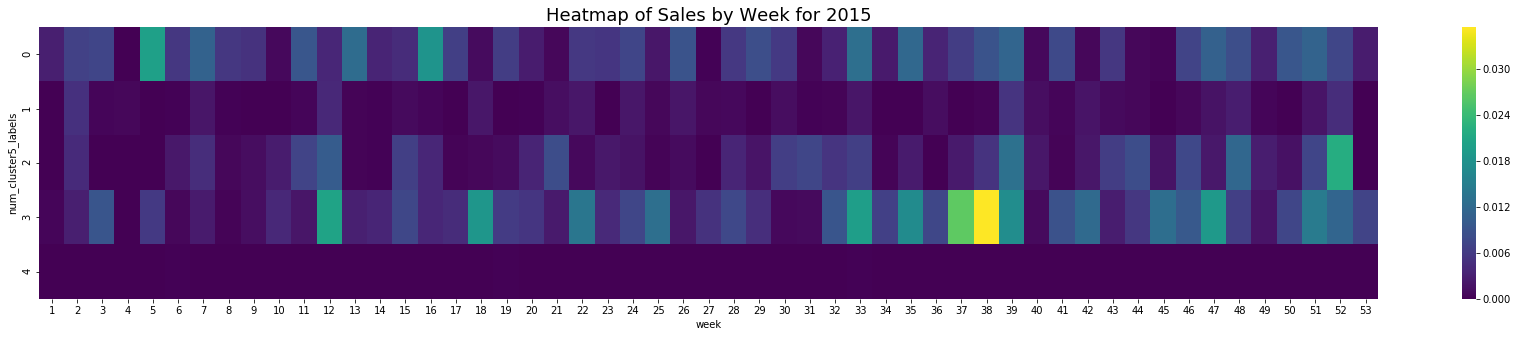

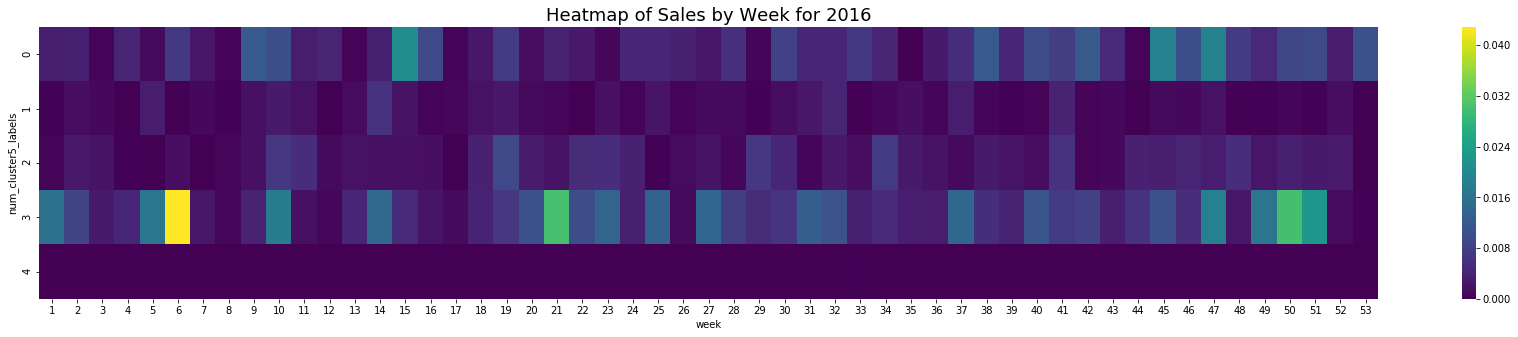

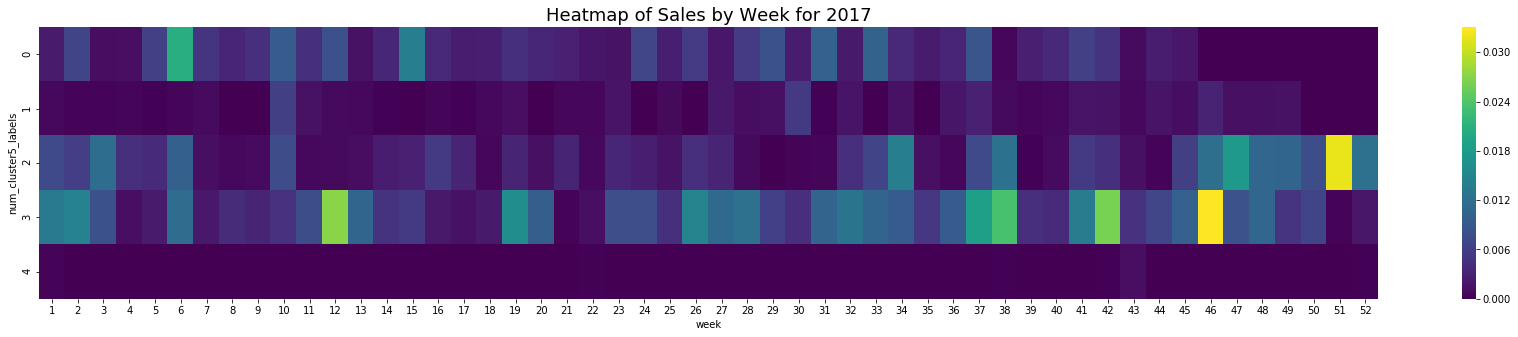

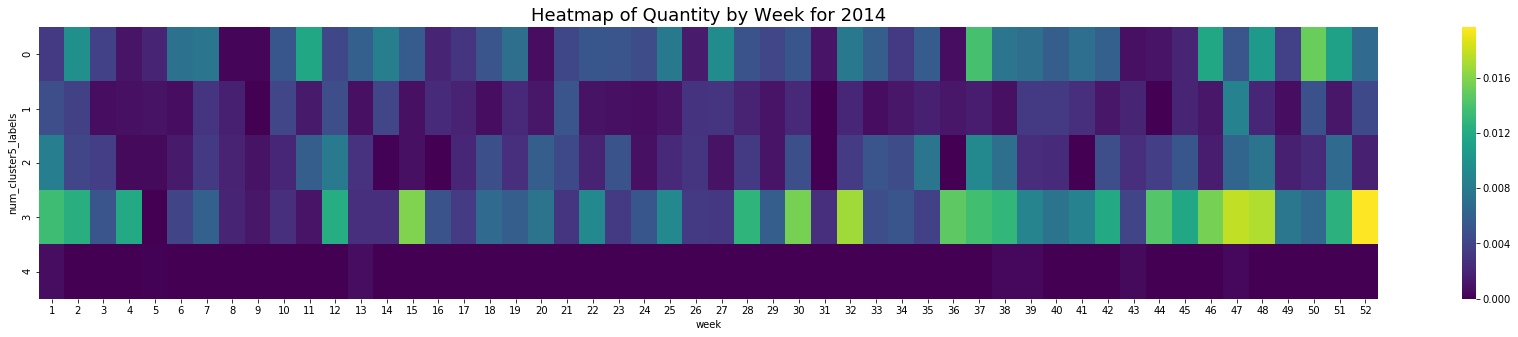

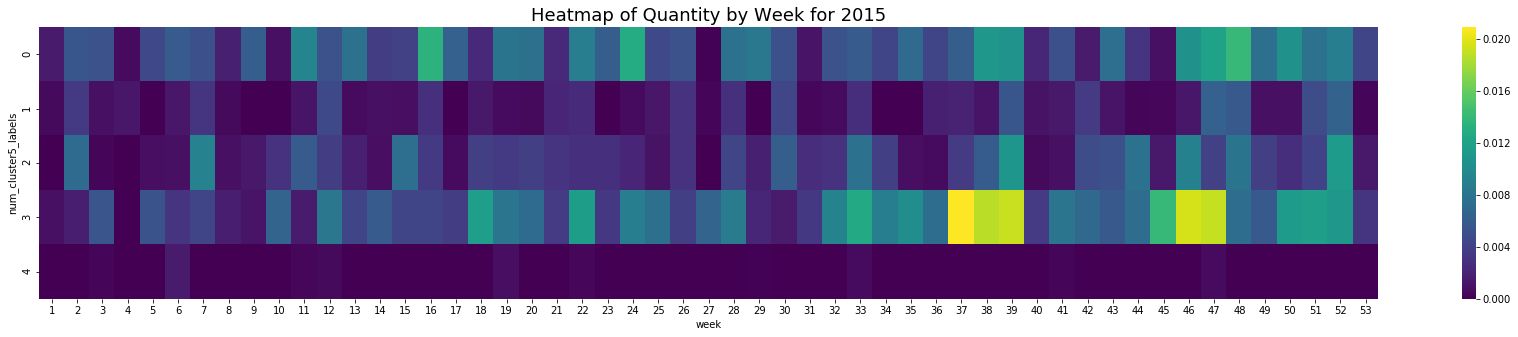

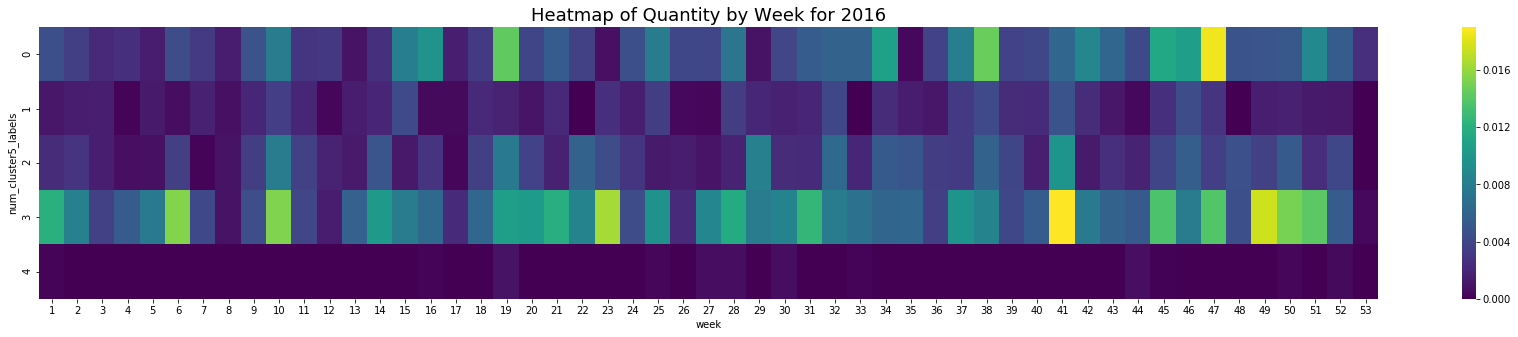

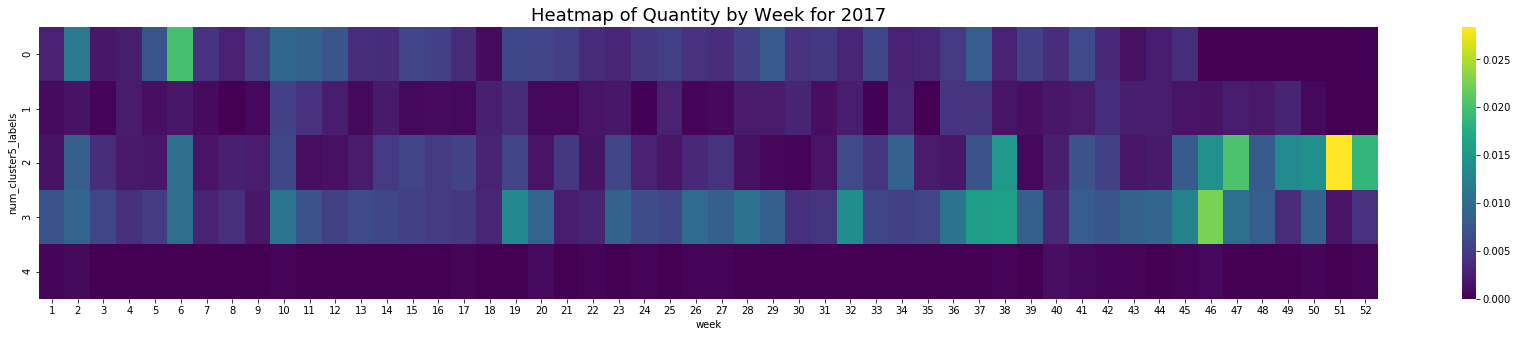

In [131]:
total_years = df_cust_Seg_new['year'].unique()
metrics=['Sales','Quantity']
for metric in metrics: 
    for yr in total_years: 
        data = pd.crosstab(df_cust_Seg_new.loc[df_cust_Seg_new['year']==yr]["num_cluster5_labels"], df_cust_Seg_new.loc[df_cust_Seg_new['year']==yr]["week"], df_cust_Seg_new.loc[df_cust_Seg_new['year']==yr][metric], aggfunc="sum", normalize=True)
        _ = plt.figure(figsize=(30, 5))
        _ = sns.heatmap(data, cmap="viridis")
        _ = plt.title("Heatmap of "+metric+" by Week for "+str(yr),size=18)